# Instructions

## Survey Analysis

As a data scientist you are required to analyse the political landscape of Europe using the **Chapel Hill Expert Survery** dataset. The dataset provides insights into the positioning of **277 political parties** in Europe based on **55 different attributes**. The dataset can be downloaded [here](https://www.chesdata.eu/2019-chapel-hill-expert-survey) and the [codebook](https://static1.squarespace.com/static/5975c9bfdb29d6a05c65209b/t/5fa04ec05d3c8218b7c91450/1604341440585/2019_CHES_codebook.pdf) provides further information on the survey attributes.

This repository contains the necessary setup and code base to help guide you in performing an analysis using different statistical methods.

## Project Setup

### Pre-requisites

Please make sure you have a Google account in order to use the [Google Colaboratory](https://colab.research.google.com/). 

### Install all python dependencies

Google Colaboratory by default already has some of the most commom dependencies used by data scientists. In case you need install some additional dependencies you can do it by runing in an empty cell something like

```bash
!pip install <python-package-name>
```

## Gearing Up for the Pairing Session

Please be sure to complete the below tasks before the pairing session.

1. Get a high-level understanding of the dataset by looking into the [codebook](https://static1.squarespace.com/static/5975c9bfdb29d6a05c65209b/t/5fa04ec05d3c8218b7c91450/1604341440585/2019_CHES_codebook.pdf) and if necessary downloading the dataset.
2. Have your coding environment ready by installing python and poetry.
3. Ensure that you are able to run all commands mentioned in this README (except for pytest errors)

**Please note that you DO NOT have to complete the code/tasks in this notebook. It is meant to be done together during pairing session.**

---

# Import modules

In [1]:
from typing import List, Optional

import os
from pathlib import Path
from itertools import cycle
from urllib.request import urlretrieve
import logging

import sqlite3
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot

from sklearn import decomposition, mixture

In [2]:
logger = logging.getLogger('my_logger')
logging.basicConfig(level=logging.DEBUG)

# 0. Data loading
Here we implemented two classes: `DataExtractor` and `EuropeanParties`.

The `DataExtractor` class downloads the data, whilst the `EuropeanParties` class was implemented to manipulate the raw table, named as `raw_table` in the SQLite DB.

After loading the data on the DataBase, you are required perform some descritive statistics using the `raw data`.

In [3]:
class DataExtractor:
    """A class to extract data from internet"""
    data_url: str = "https://cadmus.eui.eu/bitstream/handle/1814/69975/CHES_TREND_1999-2019.dta?sequence=6&isAllowed=y"

    def __init__(self):
        self.party_data = self._download_data()
        self.non_features = []
        self.index = ["party_id", "party", "country"]

    def _download_data(self) -> pd.DataFrame:

        logging.debug(f"Extracting data from {self.data_url}")
        Path("data").mkdir(exist_ok=True)
        data_path, _ = urlretrieve(
          self.data_url,
          Path("data").joinpath(*["CHES2019V3.dta"]),
        )
        raw_data =  pd.read_stata(data_path)
        clean_raw_data = self._clean_data(raw_data)
        for c in list(clean_raw_data.dtypes[clean_raw_data.dtypes == 'category'].index):
            clean_raw_data[c] = clean_raw_data[c].astype(str)
        logging.debug("Data extracted...")
        
        return clean_raw_data

    def _clean_data(self, df: pd.DataFrame):
        df = df.copy()
        mapper = {"eastwest_map": {
              'east': 1,
              'west': 0
            },
            "eumember_map": {
                'other': 0,
                'EU member state': 1
            },
            "eu_position_map": {
              "strongly opposed": 1,
              "opposed": 2,
              "somewhat opposed": 3,
              "neutral": 4,
              "somewhat in favor": 5,
              "in favor": 6,
              "strongly in favor": 7
            },
            "eu_intmark_map": {
                "neutral toward expanding EU powers on the internal market": 3,
                "stongly favors explanding EU powers on the internal market": 7,
                "stongly opposes expanding EU powers on the internal market": 1
                },
            "eu_cohesion_map": {
                "neutral towards the EU's cohesion policy": 3,
                "strongly favors the EU's cohesion policy": 7,
                "strongly opposes the EU's cohesion policy": 1
                },
            "eu_asylum_map": {
                "neutral towards a common policy on political asylum": 3,
                "strongly favors a common policy on political asylum": 7,
                "strongly opposes a common policy on political asylum": 1
                },
            "eu_foreign_map": {
                "neutral towards a common foreign and security policy": 3,
                "strongly favors a common foreign and security policy": 7,
                "strongly opposes a common foreign and security policy": 1
                },
            "lrgen_map": {
                "extreme left": 0,
                'center': 5,
                'extreme right': 10,
            },
            "lrecon_map": {
                "extreme left": 0,
                'center': 5,
                'extreme right': 10,
            },
            "galtan_map": {
                'center': 5,
                'extreme tan': 10,
                },
            "multicult_salience_map": {
                "extremely important": 10}}

        exclude = ['family', 'govt', 'eu_ep', 'eu_fiscal', 'eu_employ', 'eu_agri', 'eu_environ', 'eu_turkey', 'mip_one', 'mip_two', 'mip_three', 'multicult_sal', '_mergexxx', 'chesversion', 'year', 'eumember', 'expert']

        for k, m in mapper.items():
            col = k.replace('_map', '')
            df[col] = df[col].replace(m)
            df[col] = df[col].astype(float)

        df = df[df['year'] == 2019]
        all_nan_values = pd.isnull(df).sum()
        exclude_all_nan_cols = list(all_nan_values[all_nan_values == df.shape[0]].index)
        include = [col for col in df.columns if col not in (exclude + exclude_all_nan_cols)]
        df = df[include]
        return df

In [4]:
class EuropeanParties:
    """ Database connector class"""
    def __init__(self):
        self._conn = self._create_connection()
        self._cursor = self._conn.cursor()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.close()

    def _create_connection(self):
        import math
        conn =  sqlite3.connect("data/political-parties.db")
        conn.create_function('SQRT', 1, math.sqrt)
        conn.create_aggregate('VAR', 1, Variance)
        
        return conn

    def close(self):
        self._conn.close()

    def create_and_insert_table(self, dataframe: pd.DataFrame, table_name: str):
        dataframe.to_sql(table_name, self._conn, if_exists="replace", index=False)

    def query(self, query: str) -> pd.DataFrame:
        self._cursor.execute(query)
        column_names = list(map(lambda x: x[0], self._cursor.description))
        data = self._cursor.fetchall()
        return pd.DataFrame(data, columns=column_names)

class Variance:
    def __init__(self):
        self.n = 0
        self.sum = 0
        self.sum_squared = 0

    def step(self, value):
        try:
            if value is None:
                return None

            self.n += 1
            self.sum += value
            self.sum_squared += (value ** 2)
        except Exception as steperr:
            pass
            return None

    def finalize(self):
        avg_x_squared = self.sum_squared / self.n
        avg_x = self.sum / self.n
        variance = (avg_x_squared - (avg_x ** 2)) * (self.n / (self.n - 1))
        return variance

## 0.1. Extracting data and inserting in a table

In [5]:
extractor = DataExtractor()
raw_data = extractor.party_data
with EuropeanParties() as db:
    db.create_and_insert_table(raw_data, "raw_data")

all_data_query = """
    SELECT *
    FROM raw_data
"""
with EuropeanParties() as db:
    data = db.query(all_data_query)
display(data.head())

assert data.shape == raw_data.shape

DEBUG:root:Extracting data from https://cadmus.eui.eu/bitstream/handle/1814/69975/CHES_TREND_1999-2019.dta?sequence=6&isAllowed=y
DEBUG:root:Data extracted...


,country,eastwest,party_id,cmp_id,party,vote,seat,electionyear,epvote,eu_position,...,protectionism,regions,ethnic_minorities,nationalism,russian_interference,anti_islam_rhetoric,people_vs_elite,antielite_salience,corrupt_salience,members_vs_leadership
0,be,0.0,102.0,21322.0,PS,9.46,13.5,2019.0,9.74,6.083333,...,6.272727,6.000000,2.636364,3.454545,0.111111,2.111111,3.363636,2.181818,1.909091,7.500000
1,be,0.0,103.0,21321.0,SP/SPA,6.71,6.1,2019.0,6.45,6.000000,...,5.727273,5.333333,2.454545,3.083333,0.111111,2.222222,3.545455,2.090909,1.636364,6.818182
2,be,0.0,104.0,21111.0,ECOLO,6.14,8.8,2019.0,7.31,6.583333,...,5.818182,6.166667,2.000000,1.750000,0.111111,2.888889,5.636364,2.454545,2.363636,3.909091
3,be,0.0,105.0,21112.0,AGALEV,6.10,5.4,2019.0,7.81,6.583333,...,5.909091,6.083333,2.000000,1.916667,0.111111,2.777778,5.636364,2.363636,2.000000,4.000000
4,be,0.0,106.0,21426.0,PRL/MR,7.56,9.5,2019.0,7.06,6.500000,...,2.727273,6.416667,4.454545,3.333333,0.111111,2.333333,4.636364,1.727273,1.636364,7.000000


In [8]:
from IPython.display import display
pd.options.display.max_columns = None

## 0.2 Raw data descritive statistics
> Show some descriptive statistics

In [6]:
##### YOUR CODE GOES HERE #####
def numeric_eda(data, numerical_list) -> pd.DataFrame:
    """
    EDA of numerical features
    """
    len_list = []
    null_list = []
    mean_list = []
    std_list = []
    min_list = []
    per_25_list = []
    median_list = []
    per_75_list = []
    max_list = []
    
    data = data[numerical_list]

    for i in numerical_list:
        len_v = len(data)
        len_list.append(len_v)
        null_v = data[i].isnull().sum()
        null_list.append(null_v)
        mean_v = np.mean(data[i])
        mean_list.append(mean_v)
        std_v = np.std(data[i])
        std_list.append(std_v)
        min_v = np.min(data[i])
        min_list.append(min_v)
        per_25_v = np.percentile(data[i].dropna(), 25)
        per_25_list.append(per_25_v)
        median_v = np.median(data[i].dropna())
        median_list.append(median_v)
        per_75_v = np.percentile(data[i].dropna(), 75)
        per_75_list.append(per_75_v)
        max_v = np.max(data[i])
        max_list.append(max_v)

    numeric_df = pd.DataFrame({"variable": numerical_list,
                               "num_datos": len_list,
                               "num_null": null_list,
                               "mean": mean_list,
                               "std": std_list,
                               "min": min_list,
                               "per_25": per_25_list,
                               "median": median_list,
                               "per_75": per_75_list,
                               "max": max_list
                               })    
    numeric_df  = numeric_df.sort_values(by=["variable"])
    numeric_df = numeric_df.reset_index(drop=True)
    return numeric_df

def category_eda(data, categorical_list) -> pd.DataFrame:
    """
    EDA of categorical features
    """
    len_list = []
    null_list = []
    category_list = []
    num_category_list = []
    mode_list = []
    mode_count_list = []
    
    data = data[categorical_list]
    
    for i in categorical_list:
        len_v = len(data)
        len_list.append(len_v)
        null_v = data[i].isnull().sum()
        null_list.append(null_v)
        
        category_v = data[i].unique()
        category_list.append(category_v)
        num_category_v = len(category_v)
        num_category_list.append(num_category_v)
        mode_v = data[i].mode()[0]
        mode_list.append(mode_v)
        mode_count_v = len(data[i][data[i] == mode_v])
        mode_count_list.append(mode_count_v)

    category_df = pd.DataFrame({"variable": categorical_list,
                                "num_datos": len_list,
                                "num_null": null_list,
                                "num_category": num_category_list,
                                "category": category_list,
                                "mode": mode_list,
                                "mode_count": mode_count_list,
                               })
    category_df  = category_df.sort_values(by=["variable"])
    category_df = category_df.reset_index(drop=True)
    return category_df


categorical_list = ["country", "eastwest", "party", "electionyear"]
id_list = ["party_id", "cmp_id"]
numerical_list = list(set(data.columns) - set(categorical_list) - set(id_list))

In [7]:
numeric_eda(data, numerical_list)

,variable,num_datos,num_null,mean,std,min,per_25,median,per_75,max
0,anti_islam_rhetoric,247,1,3.073363,2.533969,0.000000,1.268182,2.309524,4.000000,9.916667
1,antielite_salience,247,0,4.536898,2.552732,0.500000,2.320513,4.000000,6.500000,10.000000
2,civlib_laworder,247,1,5.128247,2.451814,0.666667,3.129464,4.800000,7.079167,10.000000
3,corrupt_salience,247,0,4.632375,2.310307,0.000000,2.707071,4.750000,6.339744,9.687500
4,deregulation,247,0,4.707364,2.160005,0.000000,3.092157,4.777778,6.348485,9.000000
5,econ_interven,247,0,4.524939,2.099039,0.000000,3.000000,4.545455,6.000000,8.937500
6,enviro_salience,247,0,4.701825,2.137427,0.714286,3.000000,4.363636,6.000000,10.000000
7,environment,247,0,5.157339,1.909418,0.500000,4.000000,5.400000,6.426768,9.307693
8,epvote,247,26,11.574525,9.602354,0.000000,4.830000,8.480000,15.880000,54.290000
9,ethnic_minorities,247,1,4.670135,2.544216,0.333333,2.519737,4.218750,6.432692,10.000000


In [8]:
category_eda(data, categorical_list)

,variable,num_datos,num_null,num_category,category,mode,mode_count
0,country,247,0,28,"[be, dk, ge, gr, esp, fr, irl, it, nl, uk, por...",cro,14
1,eastwest,247,0,2,"[0.0, 1.0]",0,134
2,electionyear,247,0,4,"[2019.0, 2017.0, 2016.0, 2018.0]",2019,86
3,party,247,0,229,"[PS, SP/SPA, ECOLO, AGALEV, PRL/MR, VLD/PVV, P...",PS,5


# 1. Data processing

In this task you are required to implement the methods in the class `DataLoader` for processing the data. These are the required steps of data processing you must write code for (using SQL):  

>**1.1. Duplicate rows removal**  
>
>   Remove rows in which have all elements are equal to each other leaving only one of them in the dataset.   
>
>**1.2. Handle NaN values.**
>
>   Fill the null values with zeros. 
>
>**1.3. Scaling data.**  
>
>   Scale all the features in order for them to have zero mean and unit variance, i.e. $\overline{x} = 0$  and $\sigma^{2} = 1$. 
>
>**1.4. Non-feature columns removal and dataframe index setting.**  
>   Remove a list of columns, passed as argument for the function/method, from the dataset. Additionaly, set another list of columns, also passed as argument for the function or method, as index of the dataframe.  
>
Finally after implementing the steps above put them all together inside the `preprocess_data` method.

In [161]:
class DataLoader:
    """Class to load the political parties dataset"""
    def __init__(self, connector: EuropeanParties, table_columns: List, numeric_features: List):
        self.connector = connector
        self.table_columns = table_columns
        self.non_features = []
        self.numeric_features = numeric_features
        self.index = ["party_id", "party", "country"]
        self.non_numeric_columns = [col for col in table_columns if col not in numeric_features]
        
    
    def _preprocess_query(self) -> str:
        """Write a function to combine the drop duplicates,
        handle nan values and scale feature queries."""
        ##### YOUR CODE GOES HERE #####
        preprocess_syntax = f"""
        WITH newTable2 AS
        (
            WITH newTable1 AS
            (
                {self._drop_duplicates_query('raw_data')}
            )
            {self._handle_NaN_values_query('newTable1')}
        )
        {self._scale_features_query('newTable2')}
        """
        return preprocess_syntax

    def _drop_duplicates_query(self, table_name: str) -> str:
        """Write a function to remove duplicates in the DataBase table"""
        ##### YOUR CODE GOES HERE #####
        columns_syntax = ', '.join(self.table_columns)
        drop_duplicates = f"""
                            WITH newTable AS
                            (
                            SELECT {columns_syntax}, COUNT(*) as raw_count
                            FROM {table_name}
                            GROUP BY {columns_syntax}
                            HAVING raw_count == 1
                            )
                            SELECT {columns_syntax} FROM newTable"""
        return drop_duplicates

    def _scale_features_query(self, table_name: str) -> str:
        """Scale features to have zero mean and unit variance.
        This function must return a SQL query"""
        # Note SQRT and VAR functions were implemented
        ##### YOUR CODE GOES HERE #####
        query_list = []
        [query_list.append(f"""({col} - (SELECT AVG({col}) FROM {table_name}))/(SELECT SQRT(VAR({col})) 
                            FROM {table_name}) AS {col}""") for col in self.table_columns if col not in self.index]
        standardization_syntax = ', '.join(query_list)
        index_syntax = ', '.join(self.index)
        return f"""SELECT {index_syntax}, {standardization_syntax} FROM {table_name}"""

    def _handle_NaN_values_query(self, table_name: str) -> str:
        """Write a function to handle NaN values.
        This function must return a SQL query"""
        ##### YOUR CODE GOES HERE #####
        query_list = []
        [query_list.append(f"""COALESCE({col}, 0) AS {col}""") for col in self.table_columns if col not in self.index]
        coalesce_syntax = ', '.join(query_list)
        index_syntax = ', '.join(self.index)
        return f""" SELECT {index_syntax}, {coalesce_syntax} FROM {table_name} """
    
    def remove_nonfeature_cols(
        self, df: pd.DataFrame, non_features: List[str], index: List[str]
    ) -> pd.DataFrame:
        """Write a function to remove certain features cols and set certain cols as 
        indices in a dataframe"""
        ##### YOUR CODE GOES HERE #####
        data = df.drop(non_features, axis=1)
        data = data.set_index(index)
        return data

    def preprocess_data(self) -> pd.DataFrame:
        """Write a function to combine all pre-processing steps for the dataset"""
        ##### YOUR CODE GOES HERE #####
        with self.connector() as db:
            data = db.query(self._preprocess_query())
        non_features = ["eastwest", "cmp_id", "vote", "seat", "electionyear"]
        data = self.remove_nonfeature_cols(data, non_features=non_features, index=self.index)
        self.party_data = data

class TestDataLoader:
    def __init__(self, connector: EuropeanParties, raw_data: pd.DataFrame, data_loader: DataLoader):
        self.connector = connector
        self.raw_data = raw_data
        self.data_loader = data_loader

    def check_drop_duplicates_query(self):
        with self.connector() as db:
            data = db.query(self.data_loader._drop_duplicates_query('raw_data'))
        logging.debug("1. Checking drop duplicates query")
        assert data.shape == (247, 54)
        logging.debug("1. Drop duplicates passed")
        # display(data)

    def check_handle_NaN_values_query(self):
        with self.connector() as db:
            data = db.query(self.data_loader._handle_NaN_values_query('raw_data'))
        logging.debug("2. Checking handle NaN values query")
        assert pd.isnull(data).sum().sum() == 0
        logging.debug("2. Handle NaN values passed")
        # display(data)

    def check_scale_features_query(self):
        from numpy.testing import assert_allclose
        logging.debug("3. Checking scale features query")
        with self.connector() as db:
            data = db.query(self.data_loader._scale_features_query('raw_data'))
        valid_cols = [col for col in data.columns if col != 'party_id']
        assert_allclose(data[valid_cols].mean(numeric_only=True), 0, atol=1e-07)
        logging.debug("3. Scale features passed")
        # display(data.head())


In [160]:
pd.set_option('display.max_rows', 10000)

numeric_features = list([col for col in raw_data.select_dtypes(exclude=['object', "category"]).columns if col != 'party_id'])
table_columns = list(raw_data.columns)
data_loader = DataLoader(connector=EuropeanParties, table_columns=table_columns, numeric_features=numeric_features)

test_data_loader = TestDataLoader(connector=EuropeanParties, raw_data=raw_data, data_loader=data_loader)
test_data_loader.check_drop_duplicates_query()
test_data_loader.check_handle_NaN_values_query()
test_data_loader.check_scale_features_query()

DEBUG:root:1. Checking drop duplicates query
DEBUG:root:1. Drop duplicates passed
DEBUG:root:2. Checking handle NaN values query
DEBUG:root:2. Handle NaN values passed
DEBUG:root:3. Checking scale features query
DEBUG:root:3. Scale features passed


## 1.1. Data processing and descriptive statistics
> Run the data processing and then show some descriptive statistics for the processed data

In [158]:
sanitized_data

,,,,epvote,eu_position,eu_salience,eu_dissent,eu_blur,eu_intmark,eu_budgets,eu_cohesion,eu_asylum,eu_foreign,...,protectionism,regions,ethnic_minorities,nationalism,russian_interference,anti_islam_rhetoric,people_vs_elite,antielite_salience,corrupt_salience,members_vs_leadership
party_id,party,country,lrgen,,,,,,,,,,,,,,,,,,,,,
1301.0,SPO,aus,4.000000,1.385900,0.631666,-0.310227,0.735603,0.146784,-0.130940,0.561396,-0.457503,0.630060,0.876553,...,0.160278,0.865118,-0.293275,-0.446925,-0.106473,-0.338744,-0.744290,-0.913595,0.158801,0.341735
1302.0,OVP,aus,6.900000,2.480798,-0.030357,-0.635446,2.885846,0.637441,0.792013,-0.346148,-0.594900,-1.258227,-0.068415,...,-0.571350,-0.174945,0.877909,0.838820,-0.324266,1.431861,-0.326151,-0.600840,-0.273164,1.141950
1303.0,FPO,aus,9.100000,0.700310,-1.655322,0.145080,0.018855,0.497253,-1.284632,-1.556208,-2.106259,-1.844247,-1.449521,...,0.441674,0.705108,1.736777,1.822036,0.628579,2.454877,1.816811,1.197500,0.072408,0.957285
1304.0,Grune,aus,2.500000,0.383096,0.872402,0.470299,-0.339519,-0.974717,-0.054027,1.015169,-0.594900,1.346307,0.949243,...,0.329115,0.305084,-1.191183,-1.430142,0.120395,-0.653519,0.666929,-0.483557,1.195520,-1.197141
1306.0,NEOS,aus,5.900000,-0.200167,0.992769,0.730473,-0.697893,-1.044811,1.176577,1.459487,-0.869692,1.150967,1.394467,...,-1.246700,0.865118,-0.839828,-1.392326,-0.106473,-0.732212,0.376555,-0.522652,1.454699,-0.935532
102.0,PS,be,2.083333,-0.063049,0.621636,-1.173535,0.198042,-0.670977,-0.207853,0.353417,0.710365,1.122028,0.949243,...,0.523534,0.865118,-0.786592,-0.615378,-1.284170,-0.373719,-0.711029,-0.920703,-1.176366,0.310957
103.0,SP/SPA,be,3.083333,-0.399705,0.571482,-1.232666,0.018855,-0.924650,-0.207853,0.608664,0.504271,1.049680,0.949243,...,0.247255,0.491762,-0.857573,-0.755756,-1.284170,-0.330001,-0.615997,-0.956243,-1.294175,-0.066767
104.0,ECOLO,be,2.083333,-0.311704,0.922555,-0.818751,0.018855,-1.084864,-0.207853,0.693746,0.504271,1.411420,1.094622,...,0.293302,0.958457,-1.035025,-1.259970,-1.284170,-0.067689,0.476866,-0.814082,-0.980018,-1.678390
105.0,AGALEV,be,2.416667,-0.260540,0.922555,-0.818751,0.018855,-1.164972,-0.207853,0.693746,0.401223,1.411420,1.094622,...,0.339348,0.911788,-1.035025,-1.196943,-1.284170,-0.111408,0.476866,-0.849622,-1.137096,-1.628026


In [163]:
numeric_features = list([col for col in raw_data.select_dtypes(exclude=['object', "category"]).columns if col != 'party_id'])
table_columns = list(raw_data.columns)
data_loader = DataLoader(connector=EuropeanParties, table_columns=table_columns, numeric_features=numeric_features)
data_loader.preprocess_data()
sanitized_data = data_loader.party_data
##### YOUR CODE GOES HERE #####
numeric_eda(sanitized_data, sanitized_data.columns)

,variable,num_datos,num_null,mean,std,min,per_25,median,per_75,max
0,anti_islam_rhetoric,247,0,3.438545e-17,0.997974,-1.204374,-0.709260,-0.305019,0.369498,2.697516
1,antielite_salience,247,0,-2.022674e-17,0.997974,-1.578199,-0.866481,-0.209897,0.767462,2.135764
2,civlib_laworder,247,0,1.231583e-16,0.997974,-2.064938,-0.808403,-0.124315,0.795459,1.978027
3,corrupt_salience,247,0,5.393796e-17,0.997974,-2.001028,-0.831666,0.050810,0.737525,2.183641
4,deregulation,247,0,-8.989660e-17,0.997974,-2.174914,-0.746264,0.032533,0.758237,1.983300
5,econ_interven,247,0,-4.809468e-17,0.997974,-2.151352,-0.725022,0.009754,0.701308,2.097922
6,enviro_salience,247,0,1.636118e-16,0.997974,-1.861799,-0.794589,-0.157901,0.606124,2.473741
7,environment,247,0,1.078759e-16,0.997974,-2.434198,-0.604893,0.126829,0.663478,2.169218
8,epvote,247,0,-4.099285e-16,0.997974,-1.059713,-0.703616,-0.337285,0.431190,4.495615
9,ethnic_minorities,247,0,8.989660e-18,0.997974,-1.815815,-0.839828,-0.181037,0.684213,2.088132


# 2. Dimensionality reduction

Now you will need to implement the class `DimensionalityReducer` in order to project the data onto lower dimensional spaces. 

Additionaly, implement the `scatter_plot` function to visualize the datapoints projected over $\mathbb{R}^{2}$.

In [12]:
logging.basicConfig(level=logging.INFO)

In [119]:
class DimensionalityReducer:
    """Class to model a dimensionality reduction method for the given dataset.
    1. Write a function to convert the high dimensional data to 2 dimensional.
    """

    def __init__(self, data: pd.DataFrame, n_components: int = 2):
        self.n_components = n_components
        self.data = data
        self.feature_columns = data.columns
        self.model = self._model()
        
    ##### YOUR CODE GOES HERE #####
    def _model(self, n_components: int = 2):        
        return decomposition.PCA(n_components)    

In [ ]:
def scatter_plot(
    transformed_data: pd.DataFrame, 
    x: str, 
    y: str, 
    color: str, 
    splot: pyplot.subplot = None,
    labels: Optional[List[str]] = None
):
    """Write a function to generate a 2D scatter plot."""
    
    ##### YOUR CODE GOES HERE #####
    

In [ ]:
pyplot.scatter(x, y, edgecolors=None, plotnonfinite=False, data=None, **kwargs)

In [ ]:
pyplot.scatter(x, y, c=colors, alpha=0.5)
pyplot.show()

## 2.1. Dimensionality reduction

#### 2.1.1. Model training  

> Run the dimensionality reduction model training and then obtain the projected dataset.  

In [150]:
##### YOUR CODE GOES HERE #####
dim_reducer = DimensionalityReducer(data=data_loader.party_data)._model().fit(data_loader.party_data)
reduced_dim_data = dim_reducer.transform(data_loader.party_data)
reduced_dim_data = pd.DataFrame(reduced_dim_data, columns=['v_1', 'v_2'], 
                                index=data_loader.party_data.index.get_level_values('country'))

pca_components = pd.DataFrame({"feature": data_loader.party_data.columns,
                               "pc_1": list(dim_reducer.components_[0]),
                               "pc_2": list(dim_reducer.components_[1]),                           
                              })

> Plot the projected data on a scatter plot.

In [148]:
data_loader.party_data.index.get_level_values('country')

Index(['aus', 'aus', 'aus', 'aus', 'aus', 'be', 'be', 'be', 'be', 'be',
       ...
       'sv', 'sv', 'uk', 'uk', 'uk', 'uk', 'uk', 'uk', 'uk', 'uk'],
      dtype='object', name='country', length=247)

In [147]:
data_loader.party_data.index

MultiIndex([(1301.0,    'SPO', 'aus'),
            (1302.0,    'OVP', 'aus'),
            (1303.0,    'FPO', 'aus'),
            (1304.0,  'Grune', 'aus'),
            (1306.0,   'NEOS', 'aus'),
            ( 102.0,     'PS',  'be'),
            ( 103.0, 'SP/SPA',  'be'),
            ( 104.0,  'ECOLO',  'be'),
            ( 105.0, 'AGALEV',  'be'),
            ( 106.0, 'PRL/MR',  'be'),
            ...
            (1607.0,     'MP',  'sv'),
            (1610.0,     'SD',  'sv'),
            (1101.0,   'CONS',  'uk'),
            (1102.0,    'LAB',  'uk'),
            (1104.0, 'LIBDEM',  'uk'),
            (1105.0,    'SNP',  'uk'),
            (1106.0,  'PLAID',  'uk'),
            (1107.0,  'GREEN',  'uk'),
            (1108.0,   'UKIP',  'uk'),
            (1110.0, 'BREXIT',  'uk')],
           names=['party_id', 'party', 'country'], length=247)

In [151]:
reduced_dim_data.head()

,v_1,v_2
country,,
aus,-2.778556,-0.492253
aus,4.452352,-2.572187
aus,8.390992,1.642081
aus,-4.971462,2.262297
aus,-2.930095,-2.910561


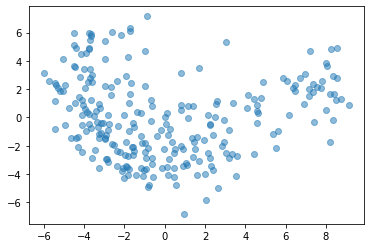

In [164]:
##### YOUR CODE GOES HERE #####
colors = data_loader.party_data.index.get_level_values('country')
pyplot.scatter(reduced_dim_data['v_1'], reduced_dim_data['v_2'], alpha=0.5) # , c=reduced_dim_data.index
pyplot.show()
###############################

> Now plot the projeted data so as to left and right parties have differnent colors. 

In [ ]:
##### YOUR CODE GOES HERE #####

###############################

# 3. Density estimation

In this step you are going to implement the class `DensityEstimator`. The main goal here is being able to find an estimate of the unobserved underlying probability density function from the data. The class must also contain a method for generating theoretical parties, _i.e._ parties data generated by the density estimator.

Note that the dimensionality reduction model is passed as an argument of this class. You must estimate the density function for the lower-dimentional data. Further in the test you will need to sample data from the estimated density function and then map it back to its original space.

Furthermore, for the `plot_density_estimation_results` - used for visualizing the estimated density's region of confidence -  the only modification you are required to make is adapting the `scatter_plot` function call accordingly to the signature you set in your implementation.

In [ ]:
import pandas as pd


class DensityEstimator:
    """Class to estimate Density/Distribution of the given data.
    1. Write a function to model the distribution of the political party dataset
    2. Write a function to randomly sample 10 parties from this distribution
    3. Map the randomly sampled 10 parties back to the original higher dimensional
    space as per the previously used dimensionality reduction technique.
    """

    def __init__(
        self, data: pd.DataFrame, dim_reducer, high_dim_feature_names, seed=42
    ):
        self.data = data
        self.dim_reducer_model = dim_reducer.model
        self.feature_names = high_dim_feature_names
        self.seed = seed
        self.model = self._model()

    ##### YOUR CODE GOES HERE #####
    

In [ ]:
def plot_density_estimation_results(
    X: pd.DataFrame,
    Y_: np.ndarray,
    means: np.ndarray,
    covariances: np.ndarray,
    title: str,
):
    """Use this function to plot the estimated distribution"""
    color_iter = cycle(["navy", "c", "cornflowerblue", "gold", "darkorange", "g"])
    pyplot.figure()
    splot = pyplot.subplot()
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = np.linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        if not np.any(Y_ == i):
            continue
        ##### YOUR CODE GOES HERE #####
        
        ###############################
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    pyplot.title(title)

## 3.1. Model training
> Execute training for the density estimation model. 

In [ ]:
##### YOUR CODE GOES HERE #####

###############################

## 3.2. Sampling from the distribution

> Draw 1,000 samples from your density estimation model and then project them back to the original space of the data.  

In [ ]:
##### YOUR CODE GOES HERE #####

###############################

## 3.3. Label the party data

> Label the original data according to the estimated density components. Also label the projected data.   

In [ ]:
##### YOUR CODE GOES HERE #####

###############################

## 3.4. Plot the confidence regions

> Plot the estimated confidence regions for each of the components of the trained density estimator alongside the real (projected) data in order to have an intuition about the model performance. 

In [ ]:
##### YOUR CODE GOES HERE #####

###############################